<a href="https://colab.research.google.com/github/ElisaTom/HDBSCAN-vs-DBSCAN-Project/blob/main/HDBSCAN_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Install the hdbscan library (required for Colab)
!pip install hdbscan

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hdbscan
from sklearn.datasets import make_blobs, make_moons
from sklearn.cluster import DBSCAN

# Setting the style to match the course Labs
sns.set_context("notebook")
plt.style.use('seaborn-v0_8-whitegrid')

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


# Unsupervised Learning Project: HDBSCAN
**Student:** [Tuo Nome]
**Course:** Unsupervised Learning (Prof. A. Rodriguez Garcia)

---

## 1. Presentation: Beyond the Global Density Threshold

### 1.1 The Intuition
In our course, we explored **DBSCAN** as a fundamental algorithm for clustering non-convex shapes. DBSCAN is powerful, but it requires a specific parameter, $\epsilon$ (epsilon), which defines the neighborhood radius. This acts as a **global density threshold**:
* If the density of a cluster is lower than this threshold, it is classified as noise.
* If we lower the threshold to find sparse clusters, we risk merging dense clusters together.

**HDBSCAN (Hierarchical Density-Based Spatial Clustering)** solves this by assuming that clusters exist at various density levels.

### 1.2 The Analogy
Imagine a mountain landscape submerged in a rising sea level (where sea level represents the density threshold):
1.  **DBSCAN** cuts the landscape at a fixed sea level (e.g., 500m). Islands appear, but we miss the peaks above 1000m or the hills at 200m.
2.  **HDBSCAN** observes the islands forming and merging as the sea level changes. It builds a **hierarchy** of all possible clusters and then selects the most **stable** ones—those that persist as islands for the longest range of sea levels.

This allows HDBSCAN to find clusters of **varying densities** simultaneously, eliminating the need for a precise $\epsilon$ parameter.

## 2. Understanding the Algorithm
Here, we implement HDBSCAN using a synthetic dataset to demonstrate its basic usage. We will use `make_blobs` to generate data, similar to **Lab 1**.

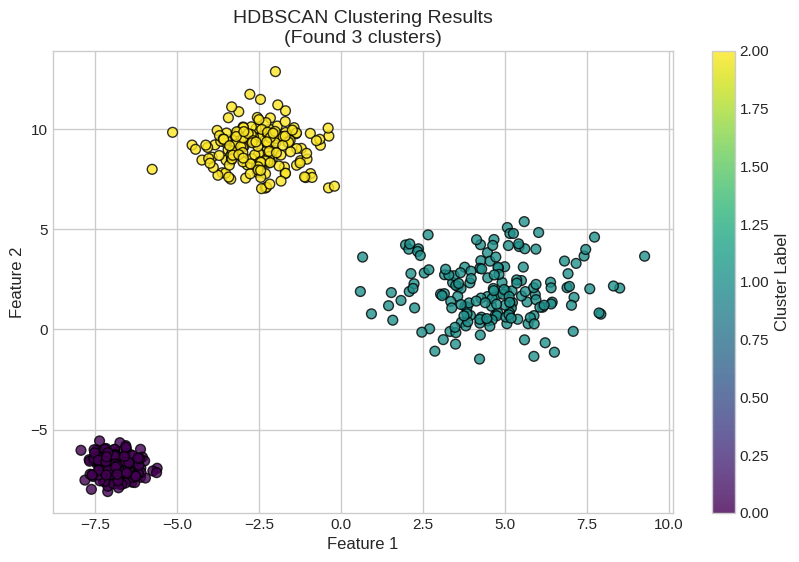

In [4]:
# --- STEP 1: Generate Synthetic Data ---
# We create a dataset with 500 points and 3 distinct centers.
# Note: standard deviations are slightly different to simulate some density variation.
X, y = make_blobs(n_samples=500, centers=3, cluster_std=[1.0, 1.5, 0.5], random_state=42)

# --- STEP 2: Initialize and Fit HDBSCAN ---
# min_cluster_size: The minimum number of samples in a group for that group to be considered a cluster.
clusterer = hdbscan.HDBSCAN(min_cluster_size=20, gen_min_span_tree=True)
cluster_labels = clusterer.fit_predict(X)

# --- STEP 3: Visualization ---
plt.figure(figsize=(10, 6))

# We use a color map (viridis) to distinguish clusters.
# Points classified as noise by HDBSCAN are labeled as -1.
plt.scatter(X[:, 0], X[:, 1], c=cluster_labels, cmap='viridis', s=50, alpha=0.8, edgecolor='k')

plt.title(f"HDBSCAN Clustering Results\n(Found {len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)} clusters)", fontsize=14)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(label='Cluster Label')
plt.show()

## 3. Hyperparameters Analysis
Unlike DBSCAN, which is very sensitive to `eps` and `min_samples`, HDBSCAN is robust. Its primary parameter is `min_cluster_size`.

* **`min_cluster_size`**: The smallest number of points required to form a cluster.
    * **Small value**: Allows the algorithm to find smaller, more fragmented micro-clusters.
    * **Large value**: Forces the algorithm to merge smaller groups into larger structures or classify them as noise.

Below, we observe the effect of changing this parameter on a "Noisy Moon" dataset (non-convex shape).

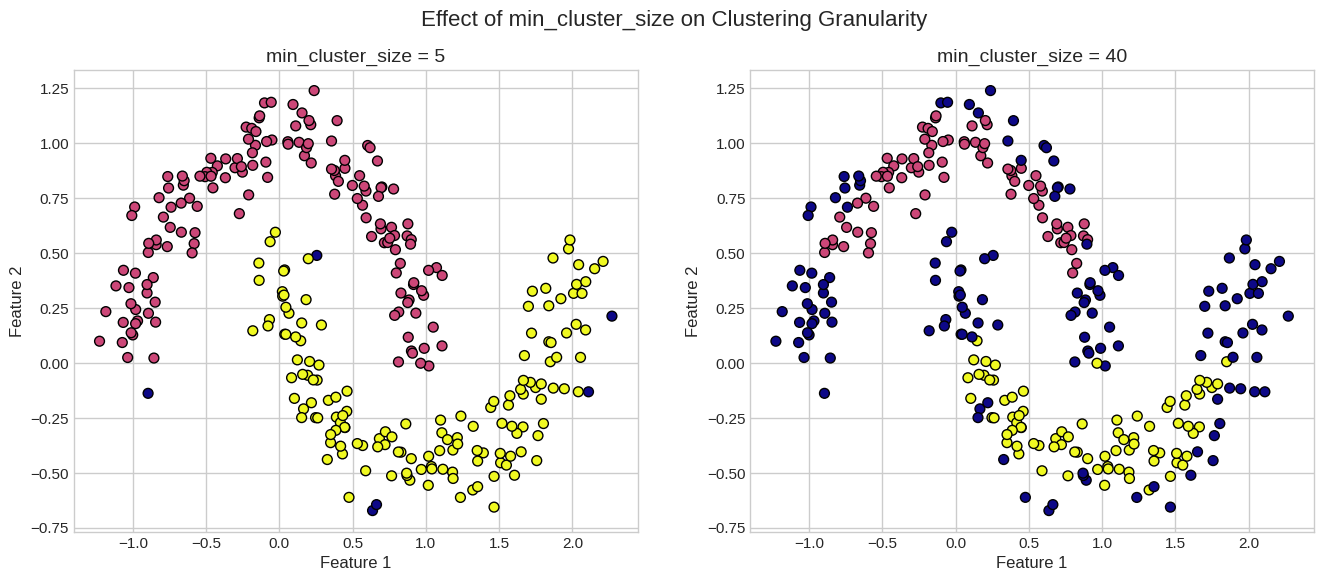

In [5]:
# Create a non-convex dataset (Moons) with some noise
X_moon, _ = make_moons(n_samples=300, noise=0.1, random_state=42)

# Define two different parameter values to compare
sizes = [5, 40]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i, size in enumerate(sizes):
    # Fit HDBSCAN with the current parameter
    clusterer = hdbscan.HDBSCAN(min_cluster_size=size)
    labels = clusterer.fit_predict(X_moon)

    # Plot
    axes[i].scatter(X_moon[:, 0], X_moon[:, 1], c=labels, cmap='plasma', s=50, edgecolor='k')
    axes[i].set_title(f"min_cluster_size = {size}", fontsize=14)
    axes[i].set_xlabel("Feature 1")
    axes[i].set_ylabel("Feature 2")

plt.suptitle("Effect of min_cluster_size on Clustering Granularity", fontsize=16)
plt.show()

## 4. Comparison: The "Variable Density" Challenge
This section demonstrates the critical advantage of HDBSCAN over DBSCAN.

As discussed in the course (**Lab 6 & 10**), density-based algorithms are superior for non-convex shapes. However, **DBSCAN** struggles when clusters have significantly different densities.
* A small `eps` detects dense clusters but misses sparse ones (treating them as noise).
* A large `eps` finds sparse clusters but merges dense ones.

We generate a synthetic dataset with **multi-density clusters** to visualize this limitation.

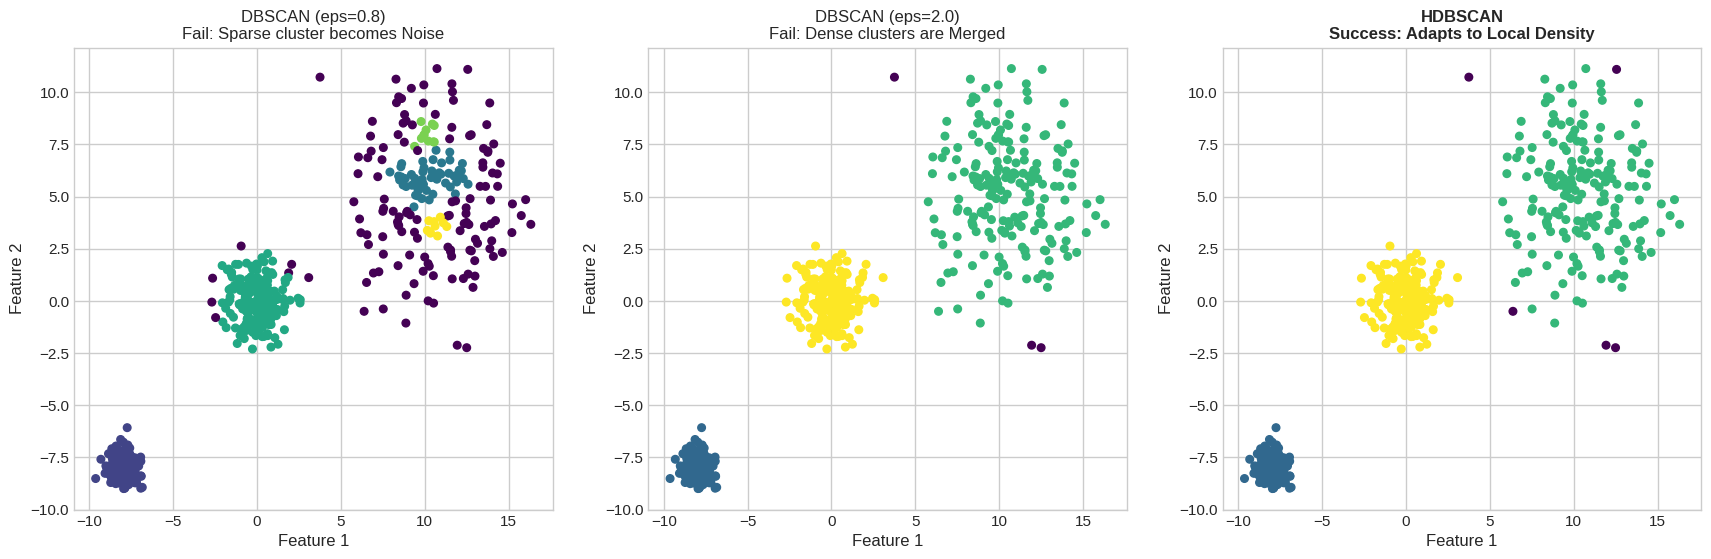

In [6]:
# --- 1. Create the "Impossible" Dataset for DBSCAN ---
# Three clusters: High density (std=0.5), Medium (std=1.0), Low density (std=2.5)
X_var, y_var = make_blobs(n_samples=600,
                          centers=[(-8, -8), (0, 0), (10, 5)],
                          cluster_std=[0.5, 1.0, 2.5],
                          random_state=42)

# --- 2. Run DBSCAN (Two attempts) ---
# Attempt A: Small epsilon (trying to separate dense clusters)
db_small = DBSCAN(eps=0.8, min_samples=10).fit(X_var)

# Attempt B: Large epsilon (trying to capture the sparse cluster)
db_large = DBSCAN(eps=2.0, min_samples=10).fit(X_var)

# --- 3. Run HDBSCAN ---
hdb = hdbscan.HDBSCAN(min_cluster_size=15).fit(X_var)

# --- 4. Plotting the Comparison ---
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

# Plot DBSCAN Small Eps
axes[0].scatter(X_var[:, 0], X_var[:, 1], c=db_small.labels_, cmap='viridis', s=30)
axes[0].set_title("DBSCAN (eps=0.8)\nFail: Sparse cluster becomes Noise", fontsize=12)

# Plot DBSCAN Large Eps
axes[1].scatter(X_var[:, 0], X_var[:, 1], c=db_large.labels_, cmap='viridis', s=30)
axes[1].set_title("DBSCAN (eps=2.0)\nFail: Dense clusters are Merged", fontsize=12)

# Plot HDBSCAN
axes[2].scatter(X_var[:, 0], X_var[:, 1], c=hdb.labels_, cmap='viridis', s=30)
axes[2].set_title("HDBSCAN\nSuccess: Adapts to Local Density", fontsize=12, fontweight='bold')

for ax in axes:
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")

plt.show()